In [4]:
import json
import pycurl
from io import BytesIO 
import os
import math
from datetime import datetime
import time
import pandas as pd
import numpy as np
import re
import contractions
import fasttext
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis
import pyLDAvis.gensim_models

C:\Users\gtanwar2\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import numpy

In [6]:
wait_time = 2
datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

'15_01_2022_16_07_46'

Use the Twitter API tool to construct query strings easier. Refer https://developer.twitter.com/en/docs/twitter-api/tweets/search/api-reference/get-tweets-search-recent

In [7]:
base_api_endpoint = "https://api.twitter.com/2/tweets/search/recent"
query_string = "query=(elon%20musk)%20lang%3Aen%20-is%3Aretweet"
query_params_dict = {
    "max_results" : "100", # enter number between 10 and 100
    "next_token" : {}
}

In [8]:
######## HEADERS ##########

# make a developer account on twitter and use the bearer token specified there
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAF5AXwEAAAAA99LgVDgzgl0I7QFAJrOHkjoJRrc%3Dr4ZU1muWyseeW8CpbM7q5Ba2X5xZIRkHXk4iZN5qCxTV1Snvf4"
header = []
header.append("Authorization: Bearer " + BEARER_TOKEN)


In [9]:
######## FUNCTIONS ########

# appending tweets from each request/page to a master list
def appendTweets(json_object, tweetList):
    #print(type(json_object))
    tweets = json_object["data"]
    print("Tweets received from request : " + str(len(tweets)))
    for tweet in tweets:
        tweetList.append(tweet)
    #print(len(tweetList))

# request api for tweets
def getTweets(num_pages, tweetList):
    count = 0
    response_code = 0
    successes = 0

    start = time.time()

    while count < num_pages :
        request_URL = base_api_endpoint + "?" + query_string

        # concatenating all query params to request URL
        for param in query_params_dict:
            if(query_params_dict[param]):
                request_URL = request_URL + "&" + str(param) + "=" + query_params_dict[param]

#         print(request_URL[55])

        b_obj = BytesIO() 
        crl = pycurl.Curl()

        # Set URL value
        crl.setopt(crl.URL, request_URL)

        # add auth token to headers
        crl.setopt(crl.HTTPHEADER, header)

        # Write bytes that are utf-8 encoded
        crl.setopt(crl.WRITEDATA, b_obj)

        # spacing requests to obey rate cap
        if(count):
            time.sleep(wait_time)

        # sending http request
        try:
            print("Sending HTTP request " + str(count+1) + " .....") 
            crl.perform() 

            response_code = crl.getinfo(crl.RESPONSE_CODE)
        except:
            print("Pycurl error!!!")

        if(response_code==200):
            print("Successful request!")
            successes+=1

            # Get the content stored in the BytesIO object (in byte characters) 
            get_body = b_obj.getvalue()

            # Decode the bytes stored in get_body (a json object) into a dict and print the result 
            print("Parsing response.....")
            response_json = json.loads(get_body)
            #print(response_json)

            appendTweets(response_json, tweetList)

            # checking if metadata available
            if "meta" in response_json.keys():
                meta_dict = response_json["meta"]

                # api v2 uses pagination, require next_token to retrieve next page. Refer https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/paginate
                # checking if next_token available
                if "next_token" in meta_dict.keys():
                    query_params_dict["next_token"] = meta_dict["next_token"]
                else:
                    print("Tweets exhausted!!!")
                    query_params_dict["next_token"] = {}
                    break
            else:
                print("No metadata!!!")
                break
            
        else:
            print("Failed request!")
        
        # End curl session
        crl.close()

        count+=1

    end = time.time()
    job_time = end - start

    return(tweetList, query_params_dict["next_token"], successes, job_time)


In [11]:
######## MAIN #########
tweetList = []

NUM_TWEETS = 5000000

num_pages = NUM_TWEETS/int(query_params_dict["max_results"])
#print(num_pages)

retrievedTweetObject = getTweets(num_pages, tweetList)
print("Number of retrieved tweets : " +str(len(retrievedTweetObject[0])))

print("-"*60)
print("JOB DETAILS :")
print("Successful requests : " + str(retrievedTweetObject[2]) + "/" + str(num_pages))
print("Time taken : " + str(retrievedTweetObject[3]))

# datetime object containing current date and time
now = datetime.now()

# formatting into file name
json_file = now.strftime("%d_%m_%Y_%H_%M_%S") + "_total_" + str(len(retrievedTweetObject[0])) + ".json"
#print(json_file)

#converting list to dict and storing as json file
dataStore = {}
dataStore["data"] = retrievedTweetObject[0]
dataStore["next_token"] = retrievedTweetObject[1]
dataStore["time"] = now.strftime("%d_%m_%Y_%H_%M_%S")

with open(json_file, "w") as outfile:
    json.dump(dataStore, outfile)


Sending HTTP request 1 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 2 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 3 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 4 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 5 .....
Successful request!
Parsing response.....
Tweets received from request : 99
Sending HTTP request 6 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 7 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 8 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 9 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 10 .....
Successful reques

Sending HTTP request 78 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 79 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 80 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 81 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 82 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 83 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 84 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 85 .....
Successful request!
Parsing response.....
Tweets received from request : 99
Sending HTTP request 86 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 87 .....
Successf

Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 155 .....
Successful request!
Parsing response.....
Tweets received from request : 99
Sending HTTP request 156 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 157 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 158 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 159 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 160 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 161 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 162 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 163 .....
Successful request!
Parsing r

Sending HTTP request 231 .....
Successful request!
Parsing response.....
Tweets received from request : 99
Sending HTTP request 232 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 233 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 234 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 235 .....
Successful request!
Parsing response.....
Tweets received from request : 99
Sending HTTP request 236 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 237 .....
Successful request!
Parsing response.....
Tweets received from request : 99
Sending HTTP request 238 .....
Successful request!
Parsing response.....
Tweets received from request : 99
Sending HTTP request 239 .....
Successful request!
Parsing response.....
Tweets received from request : 99
Sending HTTP request 240 .....
Su

Successful request!
Parsing response.....
Tweets received from request : 98
Sending HTTP request 308 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 309 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 310 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 311 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 312 .....
Successful request!
Parsing response.....
Tweets received from request : 99
Sending HTTP request 313 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 314 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 315 .....
Successful request!
Parsing response.....
Tweets received from request : 100
Sending HTTP request 316 .....
Successful request!
Parsing re

In [254]:
musk_df=pd.read_csv(r'C:\Users\gtanwar2\Downloads\elonmusk_twitter.csv\elonmusk_twitter.csv')

In [255]:
musk_df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,Fikri,Bandung,Hi There,2012-10-12 10:04:39,936,150,252,False,2021-11-02 23:59:58,"RT @Floki_Pup: @elonmusk @BillyM2k Here I am, ...",[None],Twitter for Android,False
1,Nursudiono 19,NaN,Trust your instincts,2021-10-14 01:42:13,7,207,671,False,2021-11-02 23:59:58,"RT @nathannotdev: @elonmusk @BillyM2k Yes, ind...",[None],Twitter for Android,False
2,Shaun A. Allen,NaN,The way to get started is to quit talking and ...,2021-02-26 03:48:03,4,116,106,False,2021-11-02 23:59:56,RT @FlokiZap: @elonmusk @BillyM2k He would als...,[None],Twitter Web App,False
3,PokeKishu NFT's & Video Game 🎮,NaN,PokeKishu NFT's\nThe rule is to be as strong a...,2021-07-01 21:48:09,3217,0,32,False,2021-11-02 23:59:56,1. The time has come!\nNFT Coming soon!\n\nBuy...,[None],Twitter for Android,False
4,maximcamarco,NaN,Don't think too hard.,2021-08-21 22:21:08,2,67,635,False,2021-11-02 23:59:54,RT @itsALLrisky: Super $DOGE @elonmusk https:/...,[None],Twitter for Android,False


In [256]:
musk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19081 entries, 0 to 19080
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         19079 non-null  object
 1   user_location     8752 non-null   object
 2   user_description  13890 non-null  object
 3   user_created      19081 non-null  object
 4   user_followers    19081 non-null  int64 
 5   user_friends      19081 non-null  int64 
 6   user_favourites   19081 non-null  int64 
 7   user_verified     19081 non-null  bool  
 8   date              19081 non-null  object
 9   text              19081 non-null  object
 10  hashtags          19081 non-null  object
 11  source            19081 non-null  object
 12  is_retweet        19081 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 1.6+ MB


In [257]:
documents=musk_df.text

In [258]:
sum(documents.apply(lambda x:x.find('http'))>0)/len(documents)*100

33.3473088412557

In [259]:
def remove_link(text):
    return re.sub(r'https?:\/\/\S*', '', text.lower(), flags=re.MULTILINE)

In [260]:
documents=documents.apply(remove_link)

In [261]:
def expand_contractions(text):
    expanded_words = []    
    for word in text.split():
        expanded_words.append(contractions.fix(word))   
    return ' '.join(expanded_words)

In [262]:
documents=documents.apply(expand_contractions) 

In [263]:
def get_only_alpha(text):
    alpha_text=""
    for char in text:
        if char.isalpha() or char==" ":
            alpha_text+=char
        else:
#             char==".":
            alpha_text+=" "
    return alpha_text

In [264]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\ufeff', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\n', " ",text)
    text = re.sub(r'@\S*', '', text)
    text = get_only_alpha(text)
    text = re.sub(r'[ÂàâéèÃïØº]','',text)
    text = text.strip()
    return text

In [265]:
documents=documents.apply(clean_text)

In [267]:
FASTEXT_MODEL_PATH = r'C:\Users\gtanwar2\Downloads\lid.176.bin'
model = fasttext.load_model(FASTEXT_MODEL_PATH)
def select_en_text(content):
    lang = model.predict(content)[0][0][9:11]
    if lang == 'en':
        return content
    else:
        return None

In [268]:
documents=documents.apply(select_en_text)

In [269]:
documents=documents.dropna()

In [270]:
documents=documents.apply(clean_text)

In [271]:
import spacy
def remove_stopwords(text,nlp):
    filtered_sentence =[] 
    doc=nlp(text)
    for token in doc:
        lexeme = nlp.vocab[token.text]    
        if lexeme.is_stop == False and len(token.text)>2:
            filtered_sentence.append(token.text)
    return " ".join(filtered_sentence) if len(filtered_sentence)>0 else None

In [272]:
def lemmatize(text,nlp,allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    lemmatized_sentence =[] 
    doc=nlp(text)
    for token in doc:
        lexeme = nlp.vocab[token.text]    
        if token.pos_ in allowed_postags:
            lemmatized_sentence.append(token.lemma_)
    return " ".join(lemmatized_sentence) if len(lemmatized_sentence)>0 else None

In [273]:
# text=remove_stopwords("""He determined to drop his litigation with the monastry, and relinguish his claims to the wood-cuting and 
# fishery rihgts at once. He was the more ready to do this becuase the rights had become much less valuable, and he had 
# indeed the vaguest idea where the wood and river in question were.""",spacy.load("en_core_web_sm", disable=["parser", "ner"]))
# lemmatize(text,spacy.load("en_core_web_sm", disable=["parser", "ner"]))
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
documents=documents.apply(lambda x:remove_stopwords(x,nlp))
documents=documents.dropna().apply(lambda x:lemmatize(x,nlp))

In [275]:
documents=documents.dropna()

In [282]:
documents

0                       great ceo dream team design credit
1                                    person wait buffdogec
2                                               great vike
3                  time come nft come soon buy collectible
4                                                     doge
                               ...                        
19073                                  retweet want accept
19075                              awesome highly unlikely
19077                                   great ceo judgment
19078              know appreciate talk crypto future have
19079    look accept shibainucoin payment leak system c...
Name: text, Length: 17888, dtype: object

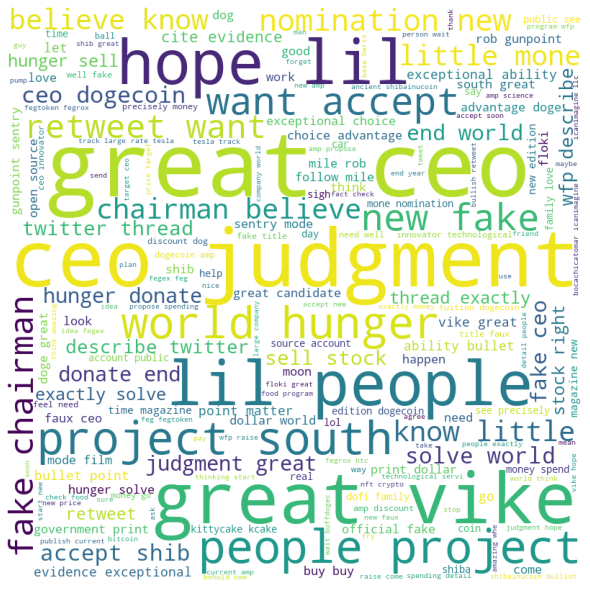

In [291]:
stopwords = set(STOPWORDS)
wordcloud= WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(' '.join(documents))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [301]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(['name bear small town call bear very hard work child father mother small mill flour buckwhe'])

In [303]:
id2word = corpora.Dictionary(documents)

NameError: name 'corpora' is not defined